# Analysis: Geant4 simulation of Ni-Cf source
The simulation launches $^{252}$Cf decays from the center of a spherical volume composed of a mixture of NiO and polyethylene. The true Monte Carlo information, including the particles produced in each event and relevant kinematic information, is stored in an HDF5 ntuple which can be read and processed in this notebook.

In [1]:
import h5py
import tables as tb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def read_hdf5_to_df(fname):
    """
    Reads an output HDF5 file from the nisource Geant4 simulation into a Pandas DataFrame.
    """
    
    # Open the file and get the ntuple.
    fn = h5py.File(fname,'r')
    ntuple = fn['default_ntuples']['nisource']
    
    # Fill a dictionary with the ntuple column values.
    df_values = {}
    for col in list(ntuple):

        # Only process H5 groups with actual data.
        if(isinstance(ntuple[col],h5py._hl.group.Group)):
            #print("Adding column",col,"...")
            if(ntuple[col]['pages'].dtype == object):
                df_values[col] = [x.decode('utf-8') for x in ntuple[col]['pages'][:]]
            else:
                df_values[col] = ntuple[col]['pages'][:]
             
    # Create the dataframe.
    df = pd.DataFrame.from_dict(df_values)
    
    # Add composite columns.
    ri = (df.xi**2 + df.yi**2 + df.zi**2)**0.5
    rf = (df.xf**2 + df.yf**2 + df.zf**2)**0.5
    Ki = (df.pxi**2 + df.pyi**2 + df.pzi**2)**0.5
    Kf = (df.pxf**2 + df.pyf**2 + df.pzf**2)**0.5
    
    df['ri'] = ri  # initial radius
    df['rf'] = rf  # final radius
    df['Ki'] = Ki  # initial kinetic energy
    df['Kf'] = Kf  # final kinetic energy
    
    # Compute time since initial decay.
    timin_evts = pd.DataFrame(df[df.ti > 0].groupby(['event'])['ti'].min())
    timin_evts = timin_evts.rename(columns={"ti": "ti_min"})
    df = pd.merge(df, timin_evts, on='event', how='outer')
    
    return df

### Read in the ntuple

In [3]:
!wget https://www.dropbox.com/s/aig7xqq1ffluig6/nicf_source_ntuple.hdf5

--2021-04-22 18:44:00--  https://www.dropbox.com/s/aig7xqq1ffluig6/nicf_source_ntuple.hdf5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6024:18::a27d:4412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/aig7xqq1ffluig6/nicf_source_ntuple.hdf5 [following]
--2021-04-22 18:44:00--  https://www.dropbox.com/s/raw/aig7xqq1ffluig6/nicf_source_ntuple.hdf5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2aaf5f7e6fb758d35f12f699dd.dl.dropboxusercontent.com/cd/0/inline/BNGckbiC5KCIp0b2pq4J2yqUSjmf62TIMdvum7eJwDb1b6F5tHecu3Ct1m86dC1lN62OEfEZqEytMEuOLkiIL2dHtHFx8eaPqmEFruGBaEWB91xrdPlVvwTJFa-OxiREaF34xbIM9M5Y53vuqpUpCv7f/file# [following]
--2021-04-22 18:44:01--  https://uc2aaf5f7e6fb758d35f12f699dd.dl.dropboxusercontent.com/cd/0/inline/BNGckbiC5KCIp0b2pq4J2yqUSjmf62TIMdvum7eJwDb1b6F5tHecu3

In [4]:
df = read_hdf5_to_df('nicf_source_ntuple.hdf5')
df.head()

,event,mass,parentID,particleName,pxf,pxi,pyf,pyi,pzf,pzi,...,xi,yf,yi,zf,zi,ri,rf,Ki,Kf,ti_min
0,0,234763.351319,0,Cf252,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,1.636367e+17
1,0,3727.379000,1,alpha,0.00000,132.848650,-0.000000,-162.682253,34.828944,34.828944,...,0.000000e+00,-1.141883e-02,0.000000e+00,2.444678e-03,0.000000e+00,0.0,1.494382e-02,212.902172,34.828944,1.636367e+17
2,0,231029.751654,1,Cm248[43.400],-132.84865,-132.848650,162.682253,162.682253,-34.828944,-34.828944,...,0.000000e+00,1.218792e-308,0.000000e+00,-2.609335e-309,0.000000e+00,0.0,0.000000e+00,212.902172,212.902172,1.636367e+17
3,0,0.510999,2,e-,0.00000,0.151762,-0.000000,-0.092054,-0.089882,-0.089882,...,-9.952832e-309,-1.018874e-03,1.218792e-308,-9.948400e-04,-2.609335e-309,0.0,2.202120e-03,0.198958,0.089882,1.636367e+17
4,0,0.510999,2,e-,0.00000,0.000233,-0.000000,-0.013831,0.004203,0.004203,...,-9.952832e-309,-7.794640e-07,1.218792e-308,2.368486e-07,-2.609335e-309,0.0,8.147602e-07,0.014457,0.004203,1.636367e+17


### Analysis: gamma energies

In [5]:
# Select gamma events that made it out of the source, with a time cut of 10 years.
df_gammas_world = df[(df.particleName == 'gamma') & (df.volFinal == 'World')]

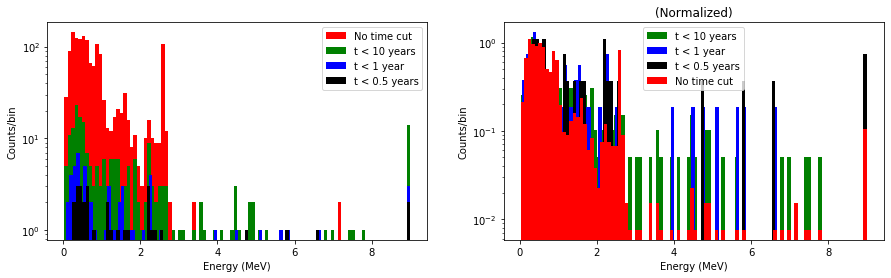

In [6]:
# Time cuts on all decays.
years = (365*24*60*60*1.0e9)  # number of ns in a year
tcut1 = 0.5*years
tcut2 = 1*years
tcut3 = 10*years

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(15.0)

# Without normalization
normed = False
ax1 = fig.add_subplot(121)
plt.hist(df_gammas_world.Kf,bins=100,density=normed,label="No time cut",color='red')
plt.hist(df_gammas_world[(df_gammas_world.ti < tcut3)].Kf,bins=100,density=normed,label="t < 10 years",color='green')
plt.hist(df_gammas_world[(df_gammas_world.ti < tcut2)].Kf,bins=100,density=normed,label="t < 1 year",color='blue')
plt.hist(df_gammas_world[(df_gammas_world.ti < tcut1)].Kf,bins=100,density=normed,label="t < 0.5 years",color='black')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.legend()

normed = True
ax2 = fig.add_subplot(122)
plt.hist(df_gammas_world[(df_gammas_world.ti < tcut3)].Kf,bins=100,density=normed,label="t < 10 years",color='green')
plt.hist(df_gammas_world[(df_gammas_world.ti < tcut2)].Kf,bins=100,density=normed,label="t < 1 year",color='blue')
plt.hist(df_gammas_world[(df_gammas_world.ti < tcut1)].Kf,bins=100,density=normed,label="t < 0.5 years",color='black')
plt.hist(df_gammas_world.Kf,bins=100,density=normed,label="No time cut",color='red')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title("(Normalized)")
plt.legend()

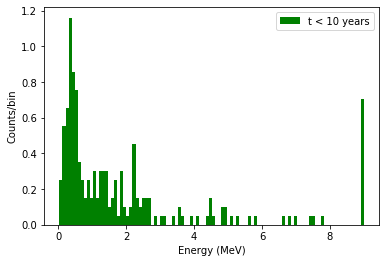

In [7]:
plt.hist(df_gammas_world[(df_gammas_world.ti < 10*years)].Kf,bins=100,density=normed,label="t < 10 years",color='green')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts/bin')
plt.legend()

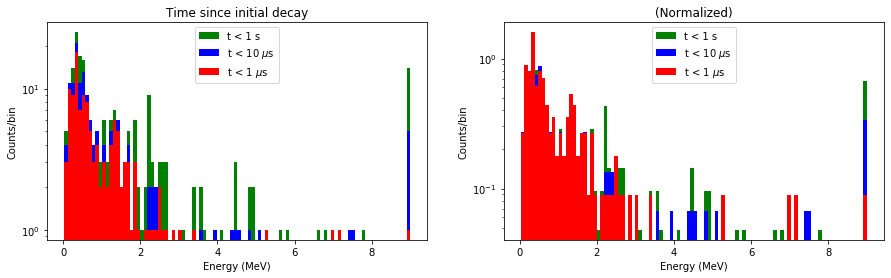

In [8]:
# Cuts on time since the initial decay.
tcut1 = 1.0e3
tcut2 = 1.0e4
tcut3 = 1.0e9

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(15.0)

# Without normalization
normed = False
ax1 = fig.add_subplot(121)
plt.hist(df_gammas_world[(df_gammas_world.ti - df_gammas_world.ti_min) < tcut3].Kf,bins=100,density=normed,label="t < 1 s",color='green')
plt.hist(df_gammas_world[(df_gammas_world.ti - df_gammas_world.ti_min) < tcut2].Kf,bins=100,density=normed,label="t < 10 $\mu$s",color='blue')
plt.hist(df_gammas_world[(df_gammas_world.ti - df_gammas_world.ti_min) < tcut1].Kf,bins=100,density=normed,label="t < 1 $\mu$s",color='red')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title("Time since initial decay")
plt.legend()

normed = True
ax2 = fig.add_subplot(122)
plt.hist(df_gammas_world[(df_gammas_world.ti - df_gammas_world.ti_min) < tcut3].Kf,bins=100,density=normed,label="t < 1 s",color='green')
plt.hist(df_gammas_world[(df_gammas_world.ti - df_gammas_world.ti_min) < tcut2].Kf,bins=100,density=normed,label="t < 10 $\mu$s",color='blue')
plt.hist(df_gammas_world[(df_gammas_world.ti - df_gammas_world.ti_min) < tcut1].Kf,bins=100,density=normed,label="t < 1 $\mu$s",color='red')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.title("(Normalized)")
plt.legend()

### Examination of specific gammas

In [11]:
egamma_low, egamma_high = 2.614, 2.615
#egamma_low, egamma_high = 2.22425, 2.22450
df_gamma_cuts = df_gammas_world[(df_gammas_world.Kf > egamma_low) & (df_gammas_world.Kf < egamma_high)]
evts = df_gamma_cuts.event.values

dparticles = {}
for evt in evts:
    unique_particles = np.unique(df[df.event == evt].particleName.values)
    for particle in unique_particles:
        if(len(particle) < 6):
            dparticles.setdefault(particle,0)
            dparticles[particle] += 1

In [12]:
# Check which nucleus[level] these gammas are coming from.
for evt in evts[0:10]:
    df_evt = df[df.event == evt]
    parent = df_evt[(df_evt.particleName == 'gamma') & (df_evt.Kf > egamma_low) & (df_evt.Kf < egamma_high)].parentID.values[0]
    print(df_evt[df_evt.trackID == parent].particleName.values[0])

Pb208[2614.522]
Pb208[2614.522]
Pb208[2614.522]
Pb208[2614.522]
Pb208[2614.522]
Pb208[2614.522]
Pb208[2614.522]
Pb208[2614.522]
Pb208[2614.522]
Pb208[2614.522]


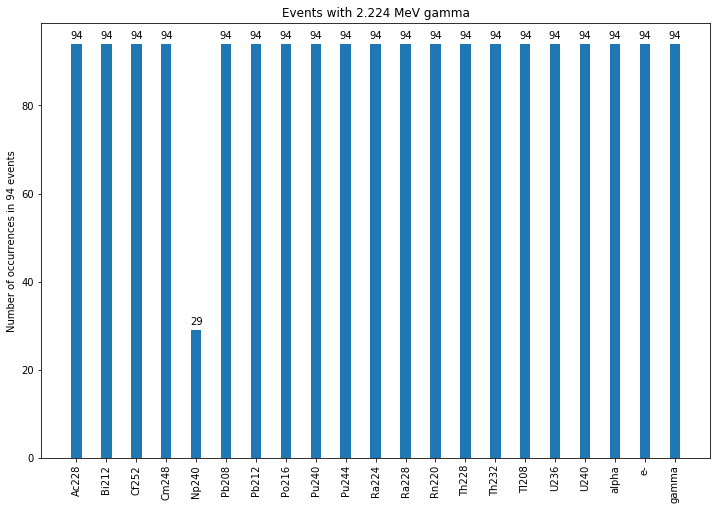

In [13]:
x = np.arange(len(dparticles.keys()))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(8.0)
fig.set_figwidth(12.0)
rects1 = ax.bar(x, dparticles.values(), width)
ax.set_ylabel('Number of occurrences in {} events'.format(len(evts)))
ax.set_xticks(x)
ax.set_xticklabels(dparticles.keys(),rotation='vertical')
plt.title("Events with 2.224 MeV gamma")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

[1.32089485e+15 1.32089485e+15 1.58121749e+22 1.58121749e+22
 5.39230042e+24 5.39230042e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.39230043e+24 5.39230043e+24 5.39230043e+24
 5.39230043e+24 5.392300

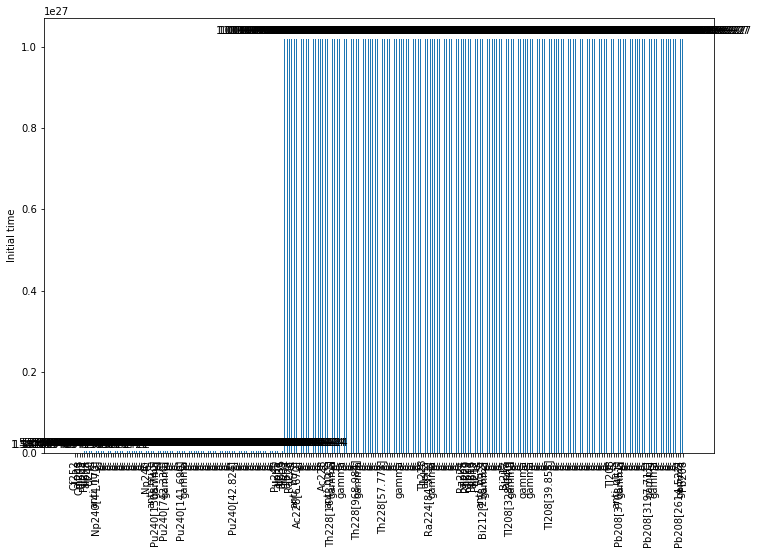

In [14]:
# Plot the distribution of initial times for a single event.
df_evt = df[df.event == evts[0]]
pnames = df_evt.particleName.values
times = df_evt.tf.values
print(times)
x = np.arange(len(pnames))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(8.0)
fig.set_figwidth(12.0)
rects1 = ax.bar(x, times, width)
ax.set_ylabel('Initial time')
ax.set_xticks(x)
ax.set_xticklabels(pnames,rotation='vertical')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

### Misc.

(array([1.21439e+05, 1.40600e+03, 1.55200e+03, 1.40900e+03, 1.02900e+03,
        1.23500e+03, 1.20600e+03, 1.22500e+03, 9.36000e+02, 1.10600e+03,
        1.06500e+03, 1.04600e+03, 9.92000e+02, 1.01100e+03, 1.04100e+03,
        1.14800e+03, 1.05800e+03, 1.12200e+03, 1.06500e+03, 9.49000e+02,
        9.52000e+02, 9.54000e+02, 8.29000e+02, 8.05000e+02, 8.49000e+02,
        8.61000e+02, 7.96000e+02, 8.70000e+02, 6.86000e+02, 6.48000e+02,
        5.52000e+02, 4.98000e+02, 4.52000e+02, 3.88000e+02, 3.65000e+02,
        0.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 6.89800e+03]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  7

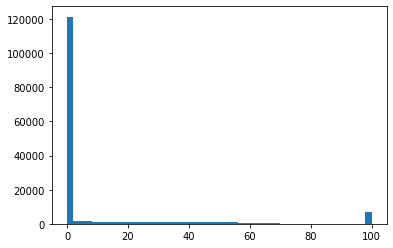

In [15]:
# Distribution of final radial values for all particles.
plt.hist(df.rf,bins=50)

In [16]:
# Select events containing Ni-59.
evts = df[df.particleName == 'Ni59'].event.values
evts

array([ 43,  43,  88,  88, 123, 127, 127, 127, 153, 166, 166, 208, 317,
       339, 411, 411, 563, 563, 567, 567, 578, 628, 640, 711, 711, 761,
       762, 846, 856, 856, 856, 897, 943, 949, 961, 986], dtype=int32)

In [17]:
# Print the energies of all gammas in one of these events.
df_gammas = df[(df.event == evts[0]) & (df.particleName == 'gamma')]
print(df_gammas.Kf.values)

[2.28378534 0.4250406  0.4060755  0.80384006 0.00478142 0.09569516
 0.0040158  0.30819517 0.59121829 1.72152924 0.57550483 1.12688085
 0.02467705]


In [18]:
# Create a list of all unique particles.
np.unique(df.particleName.values)

array(['Ac228', 'Ac228[20.190]', 'Ac228[33.070]', 'Ac228[6.280]',
       'Ac228[6.670]', 'Bi212', 'Bi212[115.183]', 'Bi212[238.632]',
       'Bi212[415.272]', 'C12', 'C13', 'Cf252', 'Cm248', 'Cm248[143.800]',
       'Cm248[43.400]', 'Co59', 'Cu63', 'Ni58', 'Ni59', 'Ni60', 'Ni61',
       'Ni63', 'Np240', 'Np240[0.000X]', 'Np240[110.700]',
       'Np240[111.600]', 'Np240[189.700]', 'Np240[280.000]',
       'Np240[44.170X]', 'Np240[44.170]', 'Np240[61.400X]', 'O16',
       'Pb208', 'Pb208[2614.522]', 'Pb208[3197.711]', 'Pb208[3475.078]',
       'Pb208[3708.451]', 'Pb208[3919.966]', 'Pb208[3961.162]',
       'Pb208[4125.347]', 'Pb212', 'Po212', 'Po212[1512.700]',
       'Po212[1620.738]', 'Po212[1679.450]', 'Po212[1805.960]',
       'Po212[727.330]', 'Po216', 'Po216[549.760]', 'Pu240',
       'Pu240[1001.940]', 'Pu240[1030.550]', 'Pu240[1037.550]',
       'Pu240[1076.220]', 'Pu240[1115.530]', 'Pu240[1130.950]',
       'Pu240[1161.530]', 'Pu240[1177.630]', 'Pu240[1308.740]',
       'Pu240[1

#### Initial particle times

(array([18011.,  4615.,  3555., ...,     0.,     0.,   102.]),
 array([0.00000000e+00, 1.44298221e+07, 2.88596441e+07, ...,
        1.44269361e+11, 1.44283791e+11, 1.44298221e+11]),
 <a list of 10000 Patch objects>)

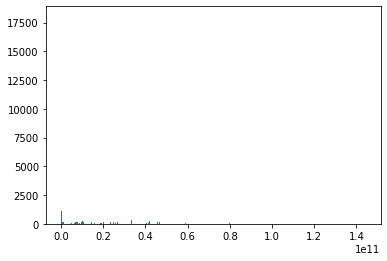

In [19]:
ti_years = df.ti/1.0e9/60/60/24/365.
plt.hist(ti_years,bins=10000)
#plt.xscale('log')

In [20]:
# Sanity check on time calculation (time is given in ns): should be about N/2, 
#  where N is the number of simulated events, for half-life 2.645 yr.
events_tcut = df[(df.ti < (2.645*365*24*60*60*1.0e9)) & (df.ti > 0)].event
len(np.unique(events_tcut))

507